In [ ]:
#| default_exp layers.self_attention

# Convolutional Self-Attention

> Convolutional self-attention layer as impemented in SAGAN.

In [ ]:
#| export
from einops import rearrange

import tensorflow as tf
from tensorflow.keras import layers

In the original SAGAN paper, self-attention is implemented as set of (1x1) convolutions applied to the output of a specific convolutional layer:

In [ ]:
#| export
class SelfAttnConv(layers.Layer):
    """Self-attention convolutional layer as implemented in SAGAN."""

    def __init__(self, 
                 emb_dim, # Embedding (channel) dim.
                 gamma=0.0, # Initial value of gamma.
                 return_attn=False, # Wether to return the attention map or not.
                 **kwargs, # Key-word arguments to be passed to the Conv2D layers.
                 ):
        super(SelfAttnConv, self).__init__()
        self.emb_dim = emb_dim
        self.gamma = gamma
        self.return_attn = return_attn
        self.query = layers.Conv2D(filters=emb_dim, kernel_size=1, **kwargs, name="query")
        self.key = layers.Conv2D(filters=emb_dim, kernel_size=1, **kwargs, name="key")
        self.value = layers.Conv2D(filters=emb_dim, kernel_size=1, **kwargs, name="value")
        
    def build(self,
             input_shape, # Input shape
             ):
        self.recover_channels = layers.Conv2D(filters=input_shape[0], kernel_size=1, name="recover_shape")
        self.gamma = tf.Variable(self.gamma, trainable=True, name="gamma")

    def call(self,
             inputs, # Inputs to the layer.
             ):
        ## 0. Store the shape of the input
        b, h, w, c = inputs.shape

        ## 1. Obtain the Query, Key, Value projections.
        query, key, value = self.query(inputs), self.key(inputs), self.value(inputs)

        ## 1.2. Flatten the spatial dims (and transpose the key).
        query = rearrange(tensor=query, pattern="b h w c -> b (h w) c")
        key = rearrange(tensor=key, pattern="b h w c -> b c (h w)")
        value = rearrange(tensor=value, pattern="b h w c -> b (h w) c")

        ## 2. Obtain the attention map by multiplying the Query and the Key and applying softmax.
        attn_map = tf.nn.softmax(query @ key, axis=-1)

        ## 3. Multiply the attention map with the value to obtain the output and recover the shape of the original image.
        output = attn_map @ value
        output = rearrange(tensor=output, pattern="b (h w) c -> b h w c", h=h, w=w)
        output = self.recover_channels(output)

        ## 4. Add the weighted value to the inputs with the corresponding global attention weight.
        output = inputs + self.gamma*output

        if self.return_attn: return attn_map, output
        else: return output

In [ ]:
sample_input = tf.random.uniform(shape=(1,32,32,3), dtype=tf.float32)
sac = SelfAttnConv(emb_dim=2, return_attn=True)
attn_map, output = sac(sample_input)
attn_map.shape, output.shape

(TensorShape([1, 1024, 1024]), TensorShape([1, 32, 32, 3]))

In [ ]:
sac.weights

[<tf.Variable 'self_attn_conv_21/gamma:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'self_attn_conv_21/query/kernel:0' shape=(1, 1, 3, 2) dtype=float32, numpy=
 array([[[[-0.41234094,  0.714978  ],
          [ 0.40519547, -1.0807463 ],
          [ 0.6298703 , -0.23957145]]]], dtype=float32)>,
 <tf.Variable 'self_attn_conv_21/query/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'self_attn_conv_21/key/kernel:0' shape=(1, 1, 3, 2) dtype=float32, numpy=
 array([[[[-0.41234094,  0.714978  ],
          [ 0.40519547, -1.0807463 ],
          [ 0.6298703 , -0.23957145]]]], dtype=float32)>,
 <tf.Variable 'self_attn_conv_21/key/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'self_attn_conv_21/value/kernel:0' shape=(1, 1, 3, 2) dtype=float32, numpy=
 array([[[[-0.41234094,  0.714978  ],
          [ 0.40519547, -1.0807463 ],
          [ 0.6298703 , -0.23957145]]]], dtype=float32)>,
 <tf.Variable 'self_attn_conv_

In [ ]:
#| hide
import matplotlib.pyplot as plt

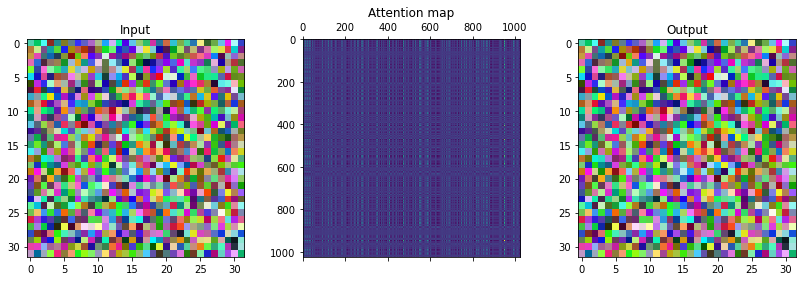

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes[0].imshow(sample_input[0])
axes[0].set_title("Input")
axes[1].matshow(attn_map[0])
axes[1].set_title("Attention map")
axes[2].imshow(output[0])
axes[2].set_title("Output")
plt.show()